In [1]:
import sys; sys.path.insert(0, '..')

import gym
import sys
import torch
import tester
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, Javascript

import pytorch_drl.models.rainbow_models as models

from pytorch_drl.algs.rainbow import Rainbow

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda:0


## 1. Define Utils:

### 1.1 Plotting:

In [3]:
def mean_filter(arr, filter_len):
    arr = np.concatenate([[arr[0]]*(filter_len-1), arr])
    filter_arr = np.ones(filter_len)/filter_len
    arr = arr
    output = list()
    for i in range(filter_len-1, len(arr)):
        conv = np.sum(filter_arr * arr[i-filter_len+1:i+1])
        output.append(conv)
    return output

def plot(scores, n=None):
    if n is not None:
        scores = mean_filter(scores, n)
    clear_output(True)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode')
    plt.show()

## 2. Create environment

In [24]:
#env_name = "CartPole-v0"
env_name = "LunarLander-v2"
env = gym.make(env_name)
env.seed(0)

state_size =  env.observation_space.shape[0]
action_size = env.action_space.n

print("State size:", state_size, "\nAction size:", action_size)

tmax = 1000
n_episodes = 2000

vmin = 0.0
vmax = 200.0

seed = 0
atoms = 51

State size: 8 
Action size: 4


/home/selo/Envs/ml-agent_/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## 3. Define networks for different algorithms

In [45]:
rainbow_model = models.RainbowNetwork(state_size, action_size, atoms)

dqn_model = models.DQNNetwork(state_size, action_size)

ns_model = models.NoisyRainbowNetwork(state_size, action_size)

dl_model = models.DuelingRainbowNetwork(state_size, action_size)

nd_model = models.NoisyDuelingRainbowNetwork(state_size, action_size)

## 4. Rainbow Test

Test the standard rainbow algorithm

In [53]:
vmin = -300
vmax = 300

seed = 0
atoms = 200

#rainbow_model = models.RainbowNetwork(state_size, action_size, atoms)
rainbow_model = models.NoisyDuelingRainbowNetwork(state_size, action_size)

# init agent:
agent = Rainbow(action_size,
                 model=rainbow_model,
                 gamma=0.99,
                 #lr=5e-4,
                 learn_every=4,
                 buf_size=int(1e5),
                 batch_size=64,
                 tau=1e-3,
                 device=device,
                 seed=0,
                 ddqn=True, #double q learning
                 categorical_dqn=False, #use c51 algortihm
                 vmin=vmin, #categorical_dqn: vmin
                 vmax=vmax, #categorical_dqn: vmax
                 atoms=atoms,#categorical_dqn: atoms
                 prioritized_replay=True, # use per
                 is_beta=0.6, # per: importance sampling
                 beta_horz=8e4, #per: beta
                 pr_alpha=0.2, # per: alpha
                 nstep=True, #use nstep returns
                 n=3, #n-step: n
                 noisy=False, #use nosiy linear layers
                )


alg_name = "rainbow_{}".format(env_name)
max_score = 200.
scores = agent.train(env, tmax, n_episodes, alg_name, max_score)
# plot the training:
plot(scores, 50)

Avg score: -151.30 i: 225                      

KeyboardInterrupt: 

### 4.1 Trained Agent Demonstration

In [ ]:
agent.test(env, max_t, render=True, num_of_episodes=5, log=True)

## 5. DQN Test

Test the DQN algorithm with Double Q Learning

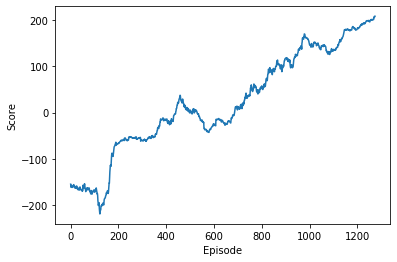

In [25]:
# init agent:
dqn_model = models.DQNNetwork(state_size, action_size, H=64)

dqn_agent = Rainbow(action_size,
                     model=dqn_model,
                     ddqn=True,
                     gamma = 0.99,
                     lr = 5e-4,
                     learn_every = 4,
                     buf_size = int(1e5),
                     batch_size = 64,
                     tau = 1e-3,
                     device = device)

alg_name = "dqn_{}".format(env_name)
max_score = 200
scores = dqn_agent.train(env, tmax, n_episodes, alg_name, max_score)
plot(scores, 50)

### 5.1 Trained Agent Demonstration

In [30]:
dqn_agent.test(env, tmax, render=True, n_episodes=5)

111.00755998391713
128.6668181061712
183.61535819866415
204.381390286356
176.73855880408024


160.88193707583773

## 6. QR - DQN Test

Test the DQN algorithm with quantized regression

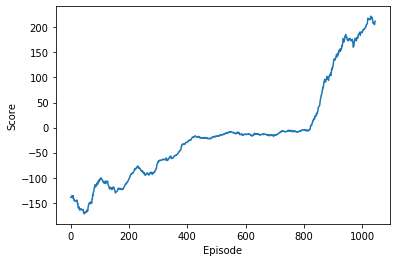

In [54]:
n_quants = 51
qrdqn_model = models.QRDQNNetwork(state_size, action_size, n_quants)

qr_dqn_agent = Rainbow(action_size,
                         model=qrdqn_model,
                         ddqn=True,
                         gamma = 0.99,
                         lr = 5e-4,
                         n_quants=n_quants,
                         quantile_regression=True,
                         learn_every = 4,
                         buf_size = int(1e5),
                         batch_size = 64,
                         tau = 1e-3,
                         device = device)

alg_name = "qr_dqn_{}".format(env_name)
max_score = 200
scores = qr_dqn_agent.train(env, tmax, n_episodes, alg_name, max_score)
plot(scores, 50)

### 6.1 Trained Agent Demonstration

In [ ]:
qr_dqn_agent.test(env, tmax, render=True, n_episodes=5)

## 7. Rainbow with Quantile Regression Test

Test the Rainbow algorithm with quantized regression instead for distributional approach (C51)

In [ ]:
n_quants = 51

qr_rainbow_model = models.QRRainbowNetwork(state_size, action_size, atoms)



# init agent:
qr_rainbow_agent = Rainbow(action_size,
                             model=rainbow_model,
                             gamma=0.99,
                             #lr=5e-4,
                             learn_every=4,
                             n_quants=n_quants,
                             quantile_regression=True,
                             buf_size=int(1e5),
                             batch_size=64,
                             tau=1e-3,
                             device=device,
                             seed=0,
                             ddqn=True, #double q learning
                             prioritized_replay=True, # use per
                             is_beta=0.6, # per: importance sampling
                             beta_horz=8e4, #per: beta
                             pr_alpha=0.2, # per: alpha
                             nstep=True, #use nstep returns
                             n=3, #n-step: n
                             noisy=False, #use nosiy linear layers
                            )


alg_name = "qr_rainbow_{}".format(env_name)
max_score = 200
scores = qr_rainbow_agent.train(env, tmax, n_episodes, alg_name, max_score)
plot(scores, 50)

### 7.1 Trained Agent Demonstration

In [ ]:
qr_rainbow_agent.test(env, tmax, render=True, n_episodes=5)